In [24]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
import urllib.request
from skimage.io import imread,imshow
from skimage.filters import threshold_otsu
from skimage.feature import canny
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.transform import resize
from skimage.feature import hog
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from sklearn.metrics import jaccard_score
from scipy.spatial import distance
from copy import deepcopy

In [2]:
img = imread("IDRiD_01.jpg")


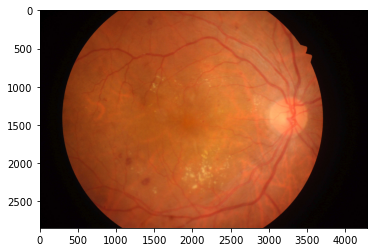

In [3]:
imgplot = plt.imshow(img)
plt.show()

In [4]:
def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    print("Dice Coeffient",((2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin)))/100)

def jaccard(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    print("Jaccard",iou_score)

In [5]:
def threshold(image):
    # cv2.cvtColor is applied over the
    # image input with applied parameters
    # to convert the image in grayscale
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # applying different thresholding
    # techniques on the input image
    # all pixels value above 120 will
    # be set to 255
    ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
    ret, thresh2 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
    ret, thresh3 = cv2.threshold(img, 120, 255, cv2.THRESH_TRUNC)
    ret, thresh4 = cv2.threshold(img, 120, 255, cv2.THRESH_TOZERO)
    ret, thresh5 = cv2.threshold(img, 120, 255, cv2.THRESH_TOZERO_INV)

    # the window showing output images
    # with the corresponding thresholding
    # techniques applied to the input images
    plt.figure(figsize=(25,5))

    plt.subplot(161).imshow(thresh1,cmap="gray"),plt.title("BINARY THRESHOLD",fontsize = 12)
    plt.subplot(162).imshow(thresh2,cmap="gray"),plt.title("INVERSE BINARY THRESHOLD",fontsize = 12)
    plt.subplot(163).imshow(thresh3,cmap="gray"),plt.title("TRUNCATE THRESHOLD",fontsize = 12)
    plt.subplot(164).imshow(thresh4,cmap="gray"),plt.title("THRESHOLD TO ZERO",fontsize = 12)
    plt.subplot(165).imshow(thresh5,cmap="gray"),plt.title("INVERTED THRESHOLD TO ZERO",fontsize = 12)
    plt.subplot(166).imshow(image),plt.title("INVERSE BINARY THRESHOLD",fontsize = 12)
    

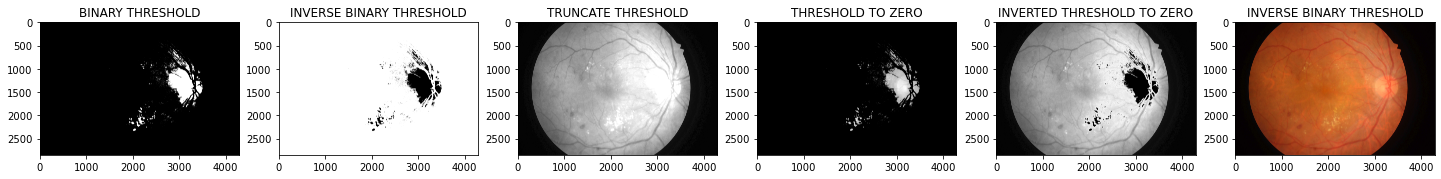

In [6]:
threshold(img)

In [7]:
def otsu(image):
    # cv2.cvtColor is applied over the
    # image input with applied parameters
    # to convert the image in grayscale
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # applying Otsu thresholding
    # as an extra flag in binary 
    # thresholding     
    ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + 
                                                cv2.THRESH_OTSU)     
    
    # the window showing output image         
    # with the corresponding thresholding         
    # techniques applied to the input image  
    plt.figure(figsize=(6,3))
    plt.subplot(121).imshow(image)
    plt.title("Orginal")
    plt.subplot(122).imshow(thresh1,cmap="gray")     
    plt.title("OTSU")
    

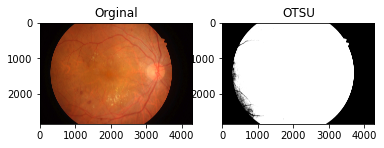

In [8]:
otsu(img)

In [9]:
def sobel(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
     
    # Calculation of Sobelx
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
     
    # Calculation of Sobely
    sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
     
    # Calculation of Laplacian
    laplacian = cv2.Laplacian(image,cv2.CV_64F)

    plt.figure(figsize=(20,4))

    plt.subplot(141).imshow(image),plt.title('original')
    plt.subplot(142).imshow(sobelx),plt.title('sobelx')
    plt.subplot(143).imshow(sobely),plt.title('sobely')
    plt.subplot(144).imshow(laplacian),plt.title('laplacian')
   #single_dice_coef(img,laplacian)
    #jaccard(img,laplacian)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


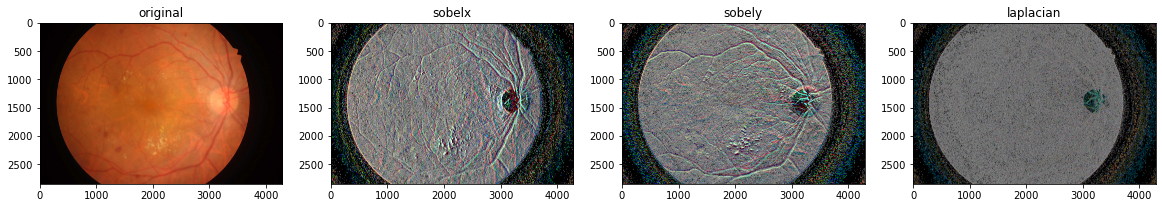

In [10]:
sobel(img)

In [11]:
def KMeansSegmentation(image,k = 3):
    # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
    pixel_vals = image.reshape((-1,3))
    
    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    
    # then perform k-means clustering wit h number of clusters defined as 3
    #also random centres are initially choosed for k-means clustering
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # convert data into 8-bit values
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    
    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((image.shape))
    
    plt.figure(figsize=(8,4))
    plt.subplot(121).imshow(image),plt.title('Original')
    plt.subplot(122).imshow(segmented_image),plt.title('K Means')
    #single_dice_coef(img,segmented_image)
    #jaccard(img,segmented_image)

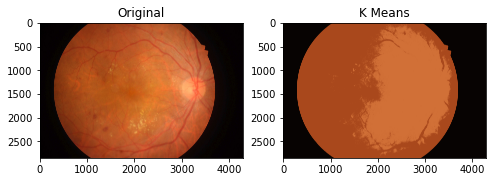

In [12]:
KMeansSegmentation(img)

In [13]:
def canny_edge_detection(img):
        green_channel=deepcopy(img)

        green_channel[:,:,0]=0
        green_channel[:,:,2]=0
        lab_img=cv2.cvtColor(green_channel,cv2.COLOR_BGR2LAB)
        
        lab_img=cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
        l,a,b=cv2.split(lab_img)
        clahe=cv2.createCLAHE(clipLimit=3.0,tileGridSize=(5,5))
        clahe_img=clahe.apply(l)
        

        equ=cv2.equalizeHist(l)
        updated_lab_img1=cv2.merge((equ,a,b))
        hist_eq_img=cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
        
        updated_lab_img2=cv2.merge((clahe_img,a,b))

        image=cv2.cvtColor(updated_lab_img2,cv2.COLOR_LAB2BGR)
        edges = canny(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255.)
        img_neg = 1 - edges

        plt.figure(figsize=(16,12))
        plt.subplot(131).imshow(image),plt.title('Original')
        plt.subplot(132).imshow(edges,cmap="gray"),plt.title('Canny')
        plt.subplot(133).imshow(img_neg,cmap="gray")
        img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        print("Original img",img.dtype)
        print("Segmented",img_neg.dtype)
        

Original img uint8
Segmented int64


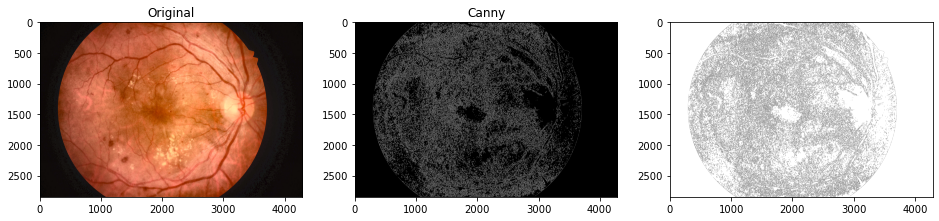

In [14]:
canny_edge_detection(img)

In [25]:
def watershed(image):

        
        green_channel=deepcopy(image)

        green_channel[:,:,0]=0
        green_channel[:,:,2]=0
        lab_img=cv2.cvtColor(green_channel,cv2.COLOR_BGR2LAB)
        l,a,b=cv2.split(lab_img)
        clahe=cv2.createCLAHE(clipLimit=3.0,tileGridSize=(5,5))
        clahe_img=clahe.apply(l)
        

        equ=cv2.equalizeHist(l)
        updated_lab_img1=cv2.merge((equ,a,b))
        hist_eq_img=cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
        
        updated_lab_img2=cv2.merge((clahe_img,a,b))

        image=cv2.cvtColor(updated_lab_img2,cv2.COLOR_LAB2BGR)
        
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        # noise removal
        kernel = np.ones((3,3),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

        # sure background area
        sure_bg = cv2.dilate(opening,kernel,iterations=3)

        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
        ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg,sure_fg)
    
        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)

        # Add one to all labels so that sure background is not 0, but 1
        markers = markers+1

        # Now, mark the region of unknown with zero
        markers[unknown==255] = 0
        img_neg = 1 - markers

        plt.figure(figsize=(16,12))

        plt.subplot(131).imshow(image)
        plt.subplot(132).imshow(markers,cmap="gray")
        plt.subplot(133).imshow(img_neg, cmap="gray")
        img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        print("Original img",img.dtype)
        print("Segmented",markers.dtype)
        
    

In [26]:
waterShed(img)

TypeError: watershed() got an unexpected keyword argument 'mask'

In [ ]:
#graphcut
def graphcut(image):
    lab_img=cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
    l,a,b=cv2.split(lab_img)
    clahe=cv2.createCLAHE(clipLimit=3.0,tileGridSize=(5,5))
    clahe_img=clahe.apply(l)

    equ=cv2.equalizeHist(l)
    updated_lab_img1=cv2.merge((equ,a,b))
    hist_eq_img=cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)

    updated_lab_img2=cv2.merge((clahe_img,a,b))
    

    img2 = clahe_img
    segment_mask1 = skimage.segmentation.felzenszwalb(img2, scale=100)
    segment_mask2 = skimage.segmentation.felzenszwalb(img2, scale=200)

    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow(segment_mask1,cmap='gray'); ax1.set_xlabel("k=100")
    ax2.imshow(segment_mask2,cmap='gray'); ax2.set_xlabel("k=200")
    fig.suptitle("Felsenszwalb's efficient graph based image segmentation")
    plt.tight_layout()
    plt.show()
    single_dice_coef(img,segement_mask2)
    jaccard(img,segement_mask2)

In [ ]:
graphcut(img)